## RL and Advanced DL: Домашнее задание 2

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

![IMG](XO.png)

### Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1.	Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2.	Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.<br>

Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [1]:
import gym
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple, defaultdict, deque
from itertools import count

import cProfile
from datetime import datetime

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam, lr_scheduler

from IPython.display import clear_output

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

### Реализация крестиков-ноликов

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win, clone=None):
        self.gameOver = False
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i, j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x + 1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i + self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i, j:j + self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([self.board[i + k, j + k] == cur_p for k in range(self.n_win)])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                    if np.all(np.array([self.board[i + k, j - k] == cur_p for k in range(self.n_win)])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----' * self.n_cols + '-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                else:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----' * self.n_cols + '-')

    def getState(self):
        return self.getHash(), self.getEmptySpaces(), self.curTurn

    def action_from_int(self, action_int):
        return int(action_int / self.n_cols), int(action_int % self.n_cols)

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]

    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

#### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [4]:
class Player:
    def __init__(self, epsilon=0.1, alpha=0.05, gamma=0.8):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        # Для каждого состояния - разное количество возможных действий
        # Q - словарь, ключ - состояние, значение - словарь действий, в котором ключи - возможные ходы, а значения - вес
        self.Q = defaultdict(dict)

    @staticmethod
    def get_empty_spaces(state, done=False):
        """
        Список координат пустых полей
        """
        empty_spaces = []
        state_array = np.array(list(map(int, state)))
        res = np.where(state_array == 1)
        if len(res[0]) == 0 or done:
            return empty_spaces
        for ind in res[0]:
            pos = env.action_from_int(ind)
            empty_spaces.append(pos)
        return empty_spaces

    def check_Q(self, state, empty_spaces, random_start=False):
        """
        Добавляет state в Q, если его еще нет,
        и проставляет возможным действиям стартовые веса (рандом, если random_start=True, иначе 0)
        """
        if state not in self.Q:
            actions = [tuple(map(int, action)) for action in empty_spaces]  # возможные действия при данном state
            if random_start:
                self.Q[state] = {action: random.random() for action in actions}
            else:
                self.Q[state] = {action: 0 for action in actions}
            
    def get_action(self, state):
        empty_spaces = self.get_empty_spaces(state)
        self.check_Q(state, empty_spaces, random_start=False)
        if random.random() > self.epsilon:
            action = max(self.Q[state].items(), key=lambda x: x[1])[0]
        else:
            action = random.choice(list(self.Q[state].keys()))
        return action

    def update_Q(self, state, action, next_state, reward, done):
        empty_spaces = self.get_empty_spaces(state)
        self.check_Q(state, empty_spaces, random_start=False)
        if next_state is None:
            self.Q[state][action] = reward
        else:
            next_empty_spaces = self.get_empty_spaces(next_state, done)
            if done:
                next_state_value = 0
            else:
                self.check_Q(next_state, next_empty_spaces, random_start=False)
                next_state_value = max(self.Q[next_state].values())
            self.Q[state][action] = (1 - self.alpha) * self.Q[state][action] + self.alpha * (reward + self.gamma * next_state_value)
            
            

Обучать будем двух игроков: одного за крестики, другого за нолики. Учиться они будут друг с другом, а проверять будем каждого на игре с рандомной стратегией.<br><br>
Чтобы обновить Q, нам необходимо знать текущее состояние среды и будущее состояние среды после хода игрока. То есть фиксируем состояние, делаем ход (состояние поменялось, но это еще не то состояние, которое нам нужно), ждем хода соперника, и, после его хода, получаем наше новое состояние для обновления Q.

In [5]:
class Game:
    def __init__(self, env, player_x, player_o):
        self.env = env
        
        self.done = False
        self.current_turn = 1
        
        self.player_x = player_x
        self.state_x = None
        self.action_x = None
        self.prev_state_x = None
        self.prev_action_x = None
        self.reward_x = 0
        
        self.player_o = player_o
        self.state_o = None
        self.action_o = None
        self.prev_state_o = None
        self.prev_action_o = None
        self.reward_o = 0
        
    def reset(self):
        self.env.reset()
        
        self.done = False
        self.current_turn = 1
        
        self.state_x = self.env.getHash()
        self.action_x = self.player_x.get_action(self.state_x)
        self.prev_state_x = None
        self.prev_action_x = None
        self.reward_x = 0
        
        self.state_o = None
        self.action_o = None
        self.prev_state_o = None
        self.prev_action_o = None
        self.reward_o = 0
        
    def set_action(self):
        if self.current_turn == 1:
            self.prev_action_x = self.action_x
            if self.done:
                self.action_x = None
            else:
                self.action_x = self.player_x.get_action(self.state_x)
        else:
            self.prev_action_o = self.action_o
            if self.done:
                self.action_o = None 
            else:
                self.action_o = self.player_o.get_action(self.state_o)

    def set_reward(self, reward):
        self.reward_x = reward
        self.reward_o = -reward
        if reward == -10:
            if self.current_turn == 1:
                self.reward_x = 0
                self.reward_o = -10
            else:
                self.reward_x = -10
                self.reward_o = 0

    def env_step(self):
        if self.current_turn == 1:
            self.prev_state_o = self.state_o  # зафиксировали состояние
            _, reward, self.done, _ = self.env.step(self.action_x)  # сделали ход соперником
            self.current_turn = self.env.curTurn
            self.state_o = self.env.getHash()  # получили новое состояние
            self.set_action()
            self.set_reward(reward)
            if self.prev_state_o is not None and self.prev_action_o is not None:
                self.player_o.update_Q(self.prev_state_o, self.prev_action_o, self.state_o, self.reward_o, self.done)
            if self.done:
                self.player_x.update_Q(self.state_x, self.action_x, None, self.reward_x, self.done)
        else:
            self.prev_state_x = self.state_x  # зафиксировали состояние
            _, reward, self.done, _ = self.env.step(self.action_o)  # сделали ход соперником
            self.current_turn = self.env.curTurn
            self.state_x = self.env.getHash()  # получили новое состояние
            self.set_action()
            self.set_reward(reward)
            if self.prev_action_x is not None:
                self.player_x.update_Q(self.prev_state_x, self.prev_action_x, self.state_x, self.reward_x, self.done)
            if self.done:
                self.player_o.update_Q(self.state_o, self.action_o, None, self.reward_o, self.done)

    def evaluate_policy(self):
        """
        Проверяем стратегии на 1000 итерациях игры с рандомным соперником: отдельно для x и для o
        """
        total_rewards_x = []
        total_rewards_o = []
        for i in range(1000):
            self.reset()
            done = False
            reward = 0
            while not done:
                # сначала крестики
                if self.env.curTurn == 1:
                    state_x = self.env.getHash()
                    action_x = self.player_x.get_action(state_x)
                    _, reward, done, _ = self.env.step(action_x)
                else:
                    action_o = random.choice(self.env.getEmptySpaces())  # рандомный соперник
                    _, reward, done, _ = self.env.step(action_o)
            self.set_reward(reward)
            total_rewards_x.append(self.reward_x)
            self.reset()
            done = False
            while not done:
                # теперь нолики
                if self.env.curTurn == -1:
                    state_o = self.env.getHash()
                    action_o = self.player_o.get_action(state_o)
                    _, reward, done, _ = self.env.step(action_o)
                else:
                    action_x = random.choice(self.env.getEmptySpaces())  # рандомный соперник
                    _, reward, done, _ = self.env.step(action_x)
            self.set_reward(reward)
            total_rewards_o.append(self.reward_o)
        return np.mean(total_rewards_x), np.mean(total_rewards_o)

    def train(self, iterations):
        rewards_x = []
        rewards_o = []
        steps = []
        for i in range(iterations):
            self.reset()
            while not self.done:
                self.env_step()
            # Каждые 5000 итераций выполняем оценку стратегий
            if (i + 1) % 1000 == 0:
                mean_reward_x, mean_reward_o = self.evaluate_policy()
                rewards_x.append(mean_reward_x)
                rewards_o.append(mean_reward_o)
                steps.append(i + 1)
                if (i + 1) % 10000 == 0:
                    print(f'{i + 1}({iterations}): [X: {mean_reward_x} | O: {mean_reward_o}]')
        return steps, rewards_x, rewards_o


Обучим для доски 3х3.

In [6]:
%%time
env = TicTacToe(3, 3, 3)

epsilon = 0.3
player_x = Player(epsilon=epsilon)
player_o = Player(epsilon=epsilon)

iterations = 200000
game = Game(env, player_x, player_o)

steps, rewards_x, rewards_o = game.train(iterations)

10000(200000): [X: 0.738 | O: 0.288]
20000(200000): [X: 0.809 | O: 0.328]
30000(200000): [X: 0.813 | O: 0.424]
40000(200000): [X: 0.827 | O: 0.478]
50000(200000): [X: 0.812 | O: 0.458]
60000(200000): [X: 0.856 | O: 0.518]
70000(200000): [X: 0.802 | O: 0.536]
80000(200000): [X: 0.84 | O: 0.567]
90000(200000): [X: 0.849 | O: 0.547]
100000(200000): [X: 0.878 | O: 0.583]
110000(200000): [X: 0.869 | O: 0.45]
120000(200000): [X: 0.858 | O: 0.52]
130000(200000): [X: 0.872 | O: 0.51]
140000(200000): [X: 0.856 | O: 0.546]
150000(200000): [X: 0.862 | O: 0.554]
160000(200000): [X: 0.848 | O: 0.561]
170000(200000): [X: 0.879 | O: 0.553]
180000(200000): [X: 0.866 | O: 0.56]
190000(200000): [X: 0.866 | O: 0.576]
200000(200000): [X: 0.888 | O: 0.599]
CPU times: user 5min 51s, sys: 716 ms, total: 5min 52s
Wall time: 5min 54s


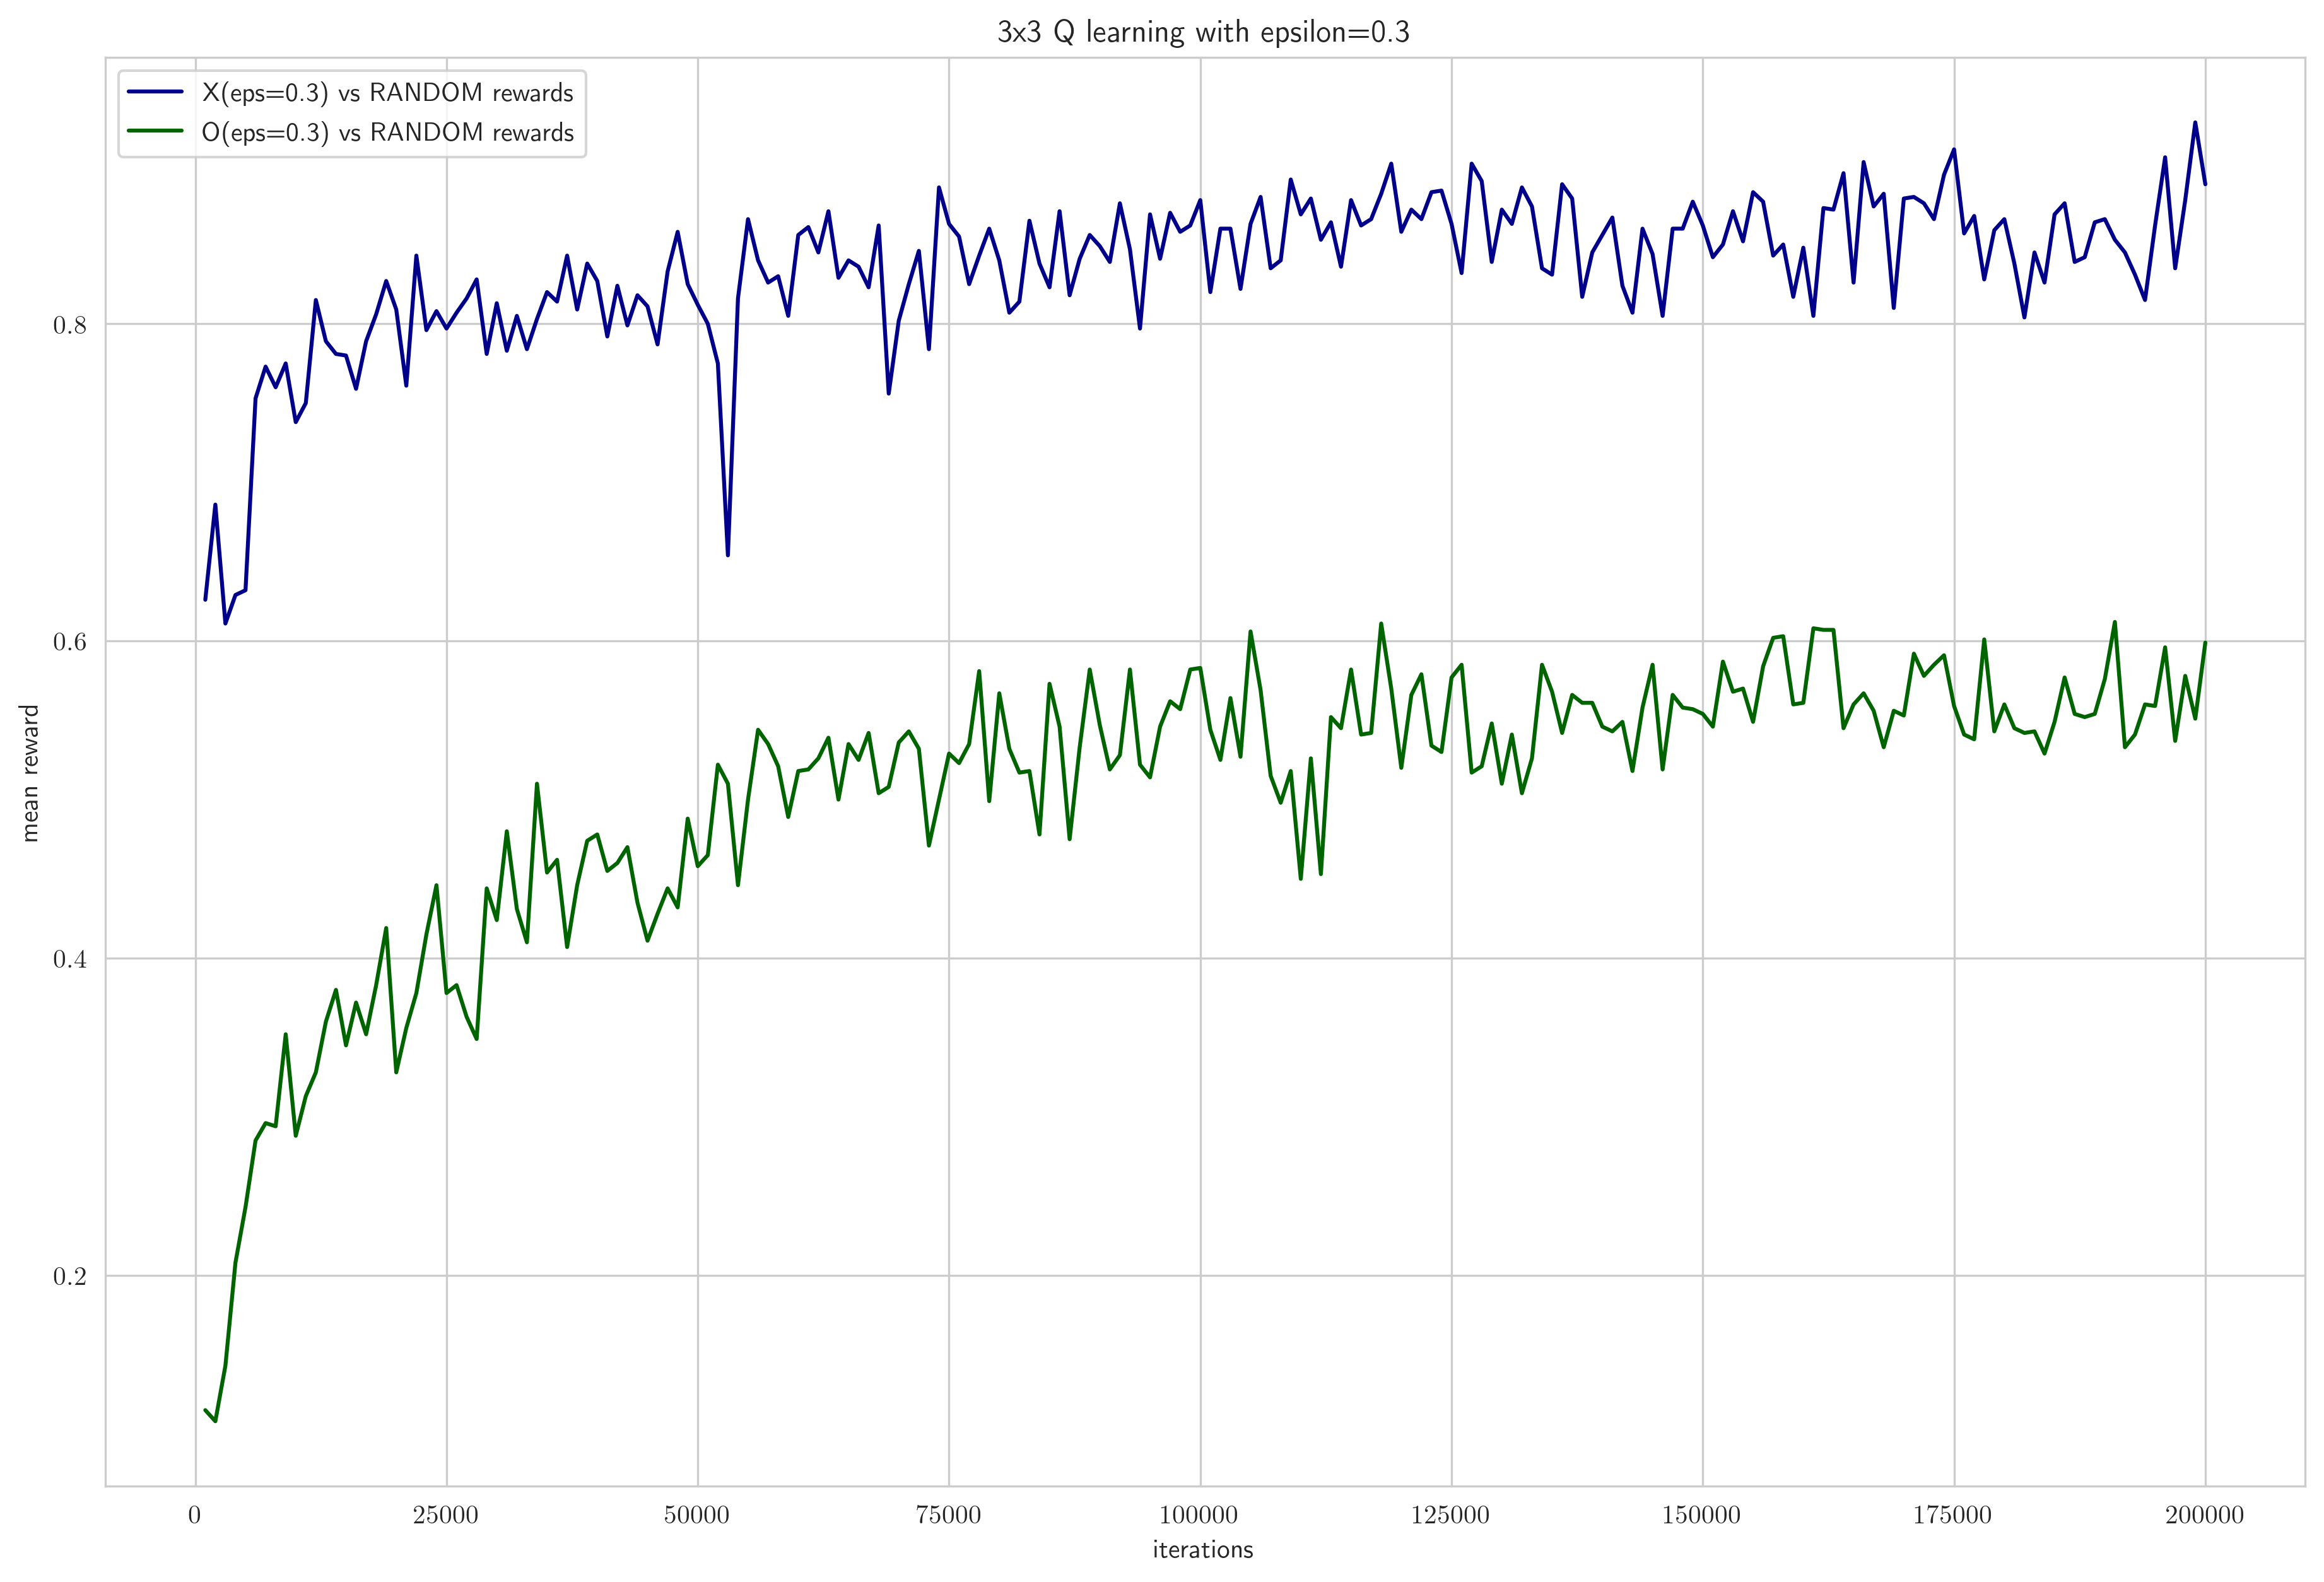

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X(eps={epsilon}) vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O(eps={epsilon}) vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
ax.legend()
ax.set_title(f'3x3 Q learning with epsilon={epsilon}')
ax.grid(True)

На доске 3х3 обе стратегии обучаются довольно быстро.

#### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Обучим на доске 4х4.

In [8]:
%%time
env = TicTacToe(4, 4, 4)

epsilon = 0.3
player_x = Player(epsilon=epsilon)
player_o = Player(epsilon=epsilon)

iterations = 2000000
game = Game(env, player_x, player_o)

steps, rewards_x, rewards_o = game.train(iterations)

10000(2000000): [X: 0.306 | O: 0.13]
20000(2000000): [X: 0.363 | O: 0.131]
30000(2000000): [X: 0.294 | O: 0.099]
40000(2000000): [X: 0.381 | O: 0.108]
50000(2000000): [X: 0.358 | O: 0.064]
60000(2000000): [X: 0.388 | O: 0.052]
70000(2000000): [X: 0.407 | O: 0.076]
80000(2000000): [X: 0.416 | O: 0.118]
90000(2000000): [X: 0.383 | O: 0.077]
100000(2000000): [X: 0.4 | O: 0.1]
110000(2000000): [X: 0.395 | O: 0.126]
120000(2000000): [X: 0.385 | O: 0.117]
130000(2000000): [X: 0.349 | O: 0.106]
140000(2000000): [X: 0.409 | O: 0.127]
150000(2000000): [X: 0.441 | O: 0.054]
160000(2000000): [X: 0.453 | O: 0.065]
170000(2000000): [X: 0.42 | O: 0.106]
180000(2000000): [X: 0.402 | O: 0.119]
190000(2000000): [X: 0.395 | O: 0.111]
200000(2000000): [X: 0.446 | O: 0.106]
210000(2000000): [X: 0.428 | O: 0.081]
220000(2000000): [X: 0.402 | O: 0.107]
230000(2000000): [X: 0.419 | O: 0.121]
240000(2000000): [X: 0.396 | O: 0.114]
250000(2000000): [X: 0.415 | O: 0.147]
260000(2000000): [X: 0.494 | O: 0.109]
2

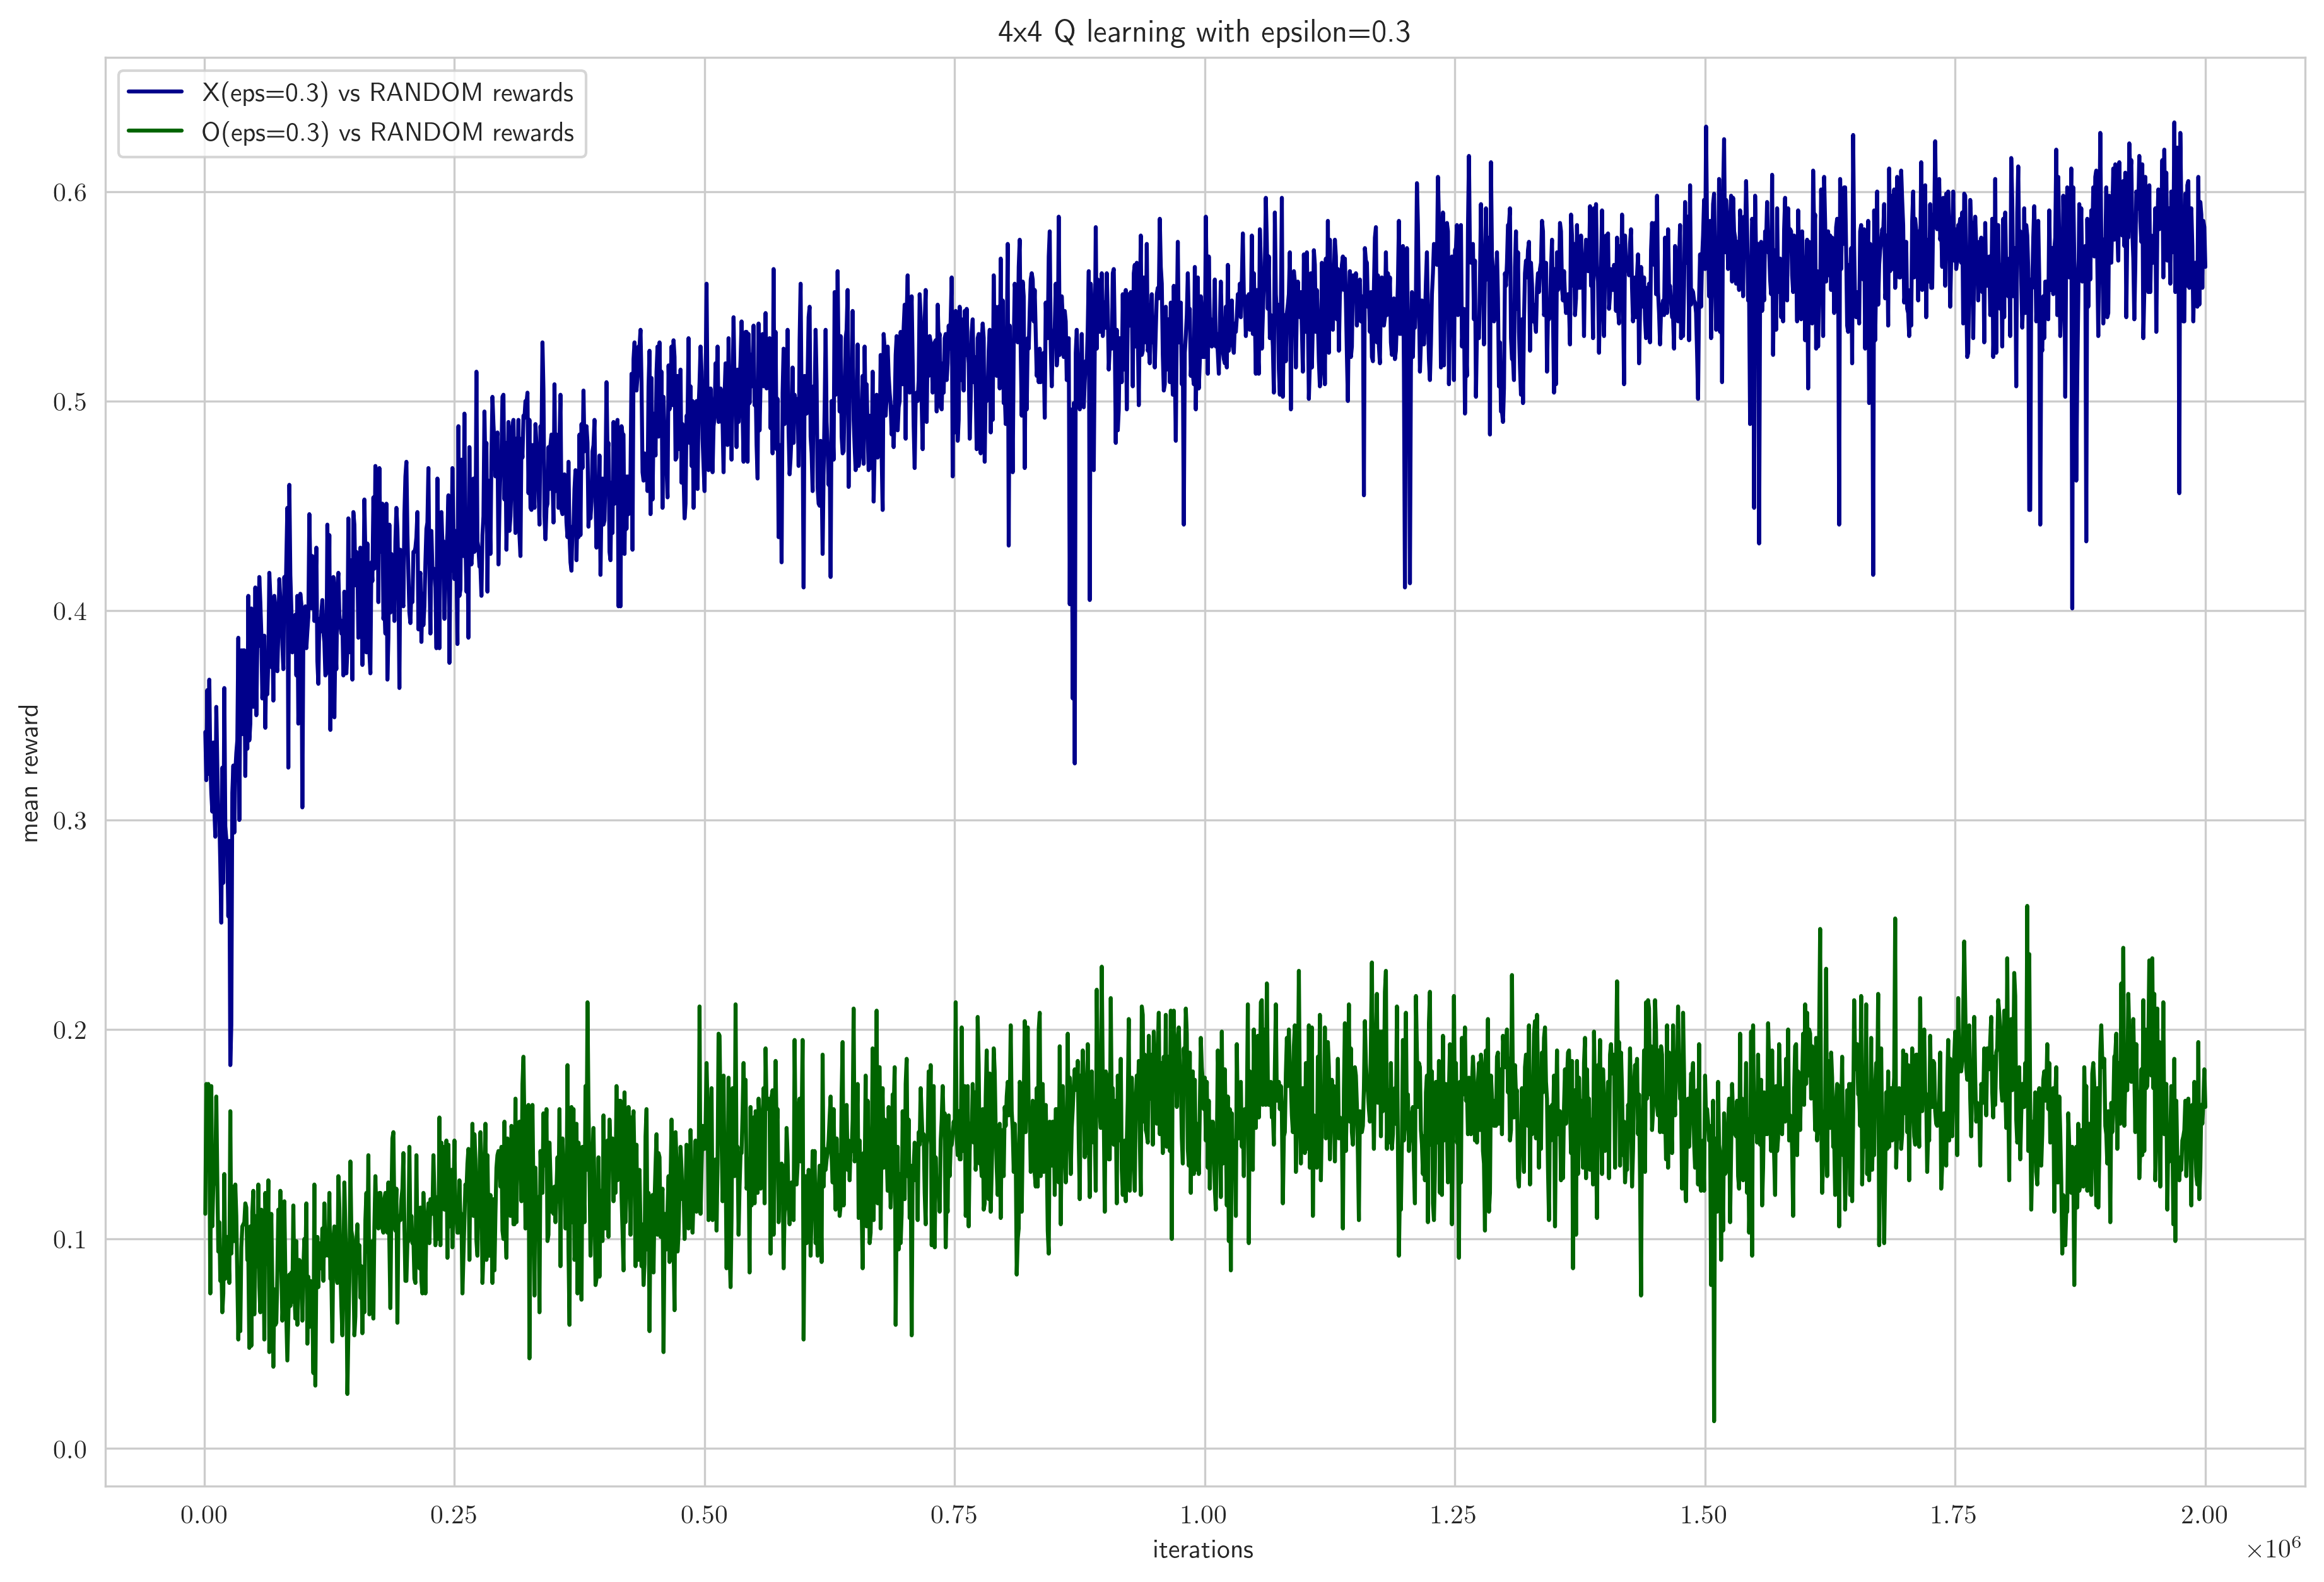

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X(eps={epsilon}) vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O(eps={epsilon}) vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
ax.legend()
ax.set_title(f'4x4 Q learning with epsilon={epsilon}')
ax.grid(True)

На доске 4х4 ситуация хуже. У крестиков видна положительная динамика, нолики застряли примерно на 0.2.

Обучим на доске 5х5.

In [ ]:
%%time
env = TicTacToe(5, 5, 5)

epsilon = 0.3
player_x = Player(epsilon=epsilon)
player_o = Player(epsilon=epsilon)

iterations = 500000
game = Game(env, player_x, player_o)

steps, rewards_x, rewards_o = game.train(iterations)

10000(500000): [X: 0.428 | O: 0.164]
20000(500000): [X: 0.418 | O: 0.177]
30000(500000): [X: 0.433 | O: 0.183]
40000(500000): [X: 0.43 | O: 0.196]
50000(500000): [X: 0.463 | O: 0.199]
60000(500000): [X: 0.453 | O: 0.164]
70000(500000): [X: 0.388 | O: 0.196]
80000(500000): [X: 0.411 | O: 0.163]
90000(500000): [X: 0.381 | O: 0.114]
100000(500000): [X: 0.397 | O: 0.202]
110000(500000): [X: 0.392 | O: 0.201]
120000(500000): [X: 0.442 | O: 0.117]
130000(500000): [X: 0.427 | O: 0.103]
140000(500000): [X: 0.411 | O: 0.152]
150000(500000): [X: 0.34 | O: 0.12]
160000(500000): [X: 0.447 | O: 0.106]
170000(500000): [X: 0.417 | O: 0.127]
180000(500000): [X: 0.5 | O: 0.152]
190000(500000): [X: 0.378 | O: 0.126]
200000(500000): [X: 0.458 | O: 0.098]
210000(500000): [X: 0.423 | O: 0.136]
220000(500000): [X: 0.452 | O: 0.158]
230000(500000): [X: 0.414 | O: 0.119]


In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(steps, rewards_x, c='DarkBlue', label=f'X(eps={epsilon}) vs RANDOM rewards')
ax.plot(steps, rewards_o, c='DarkGreen', label=f'O(eps={epsilon}) vs RANDOM rewards')
ax.set_xlabel('iterations')
ax.set_ylabel('mean reward')
ax.legend()
ax.set_title(f'5x5 Q learning with epsilon={epsilon}')
ax.grid(True)

На доске 5х5 учится слишком долго и положительная динамика не наблюдается ни у крестиков, ни у ноликов.